# Ensamble NN + XGBoost con pipeline preprocessing.py


Este notebook cumple con el requisito del ejercicio: mantener el mismo pipeline de preprocesamiento que el modelo Random Forest original.

✅ Se usa `preprocessing.py` para transformar los datos  
✅ Entrenamiento de red neuronal (PyTorch) y modelo XGBoost  
✅ Ensamble por promedio  
✅ Comparación directa con el baseline de Random Forest


In [13]:

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from preprocessing import get_preprocessor
import xgboost as xgb
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [14]:

housing = pd.read_csv("housing.csv").dropna()
X = housing.drop("median_house_value", axis=1)
y = housing["median_house_value"]

X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42)


In [15]:

y_scaler = StandardScaler()
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1)).astype(np.float32)
y_valid_scaled = y_scaler.transform(y_valid.values.reshape(-1, 1)).astype(np.float32)
y_test_scaled = y_scaler.transform(y_test.values.reshape(-1, 1)).astype(np.float32)

# Aplicar pipeline de preprocessing.py
preprocessor = get_preprocessor(housing)
X_train_prep = preprocessor.fit_transform(X_train)
X_valid_prep = preprocessor.transform(X_valid)
X_test_prep = preprocessor.transform(X_test)


In [16]:

X_train_tensor = torch.tensor(X_train_prep.astype(np.float32))
X_valid_tensor = torch.tensor(X_valid_prep.astype(np.float32)).to(device)
X_test_tensor = torch.tensor(X_test_prep.astype(np.float32)).to(device)
y_train_tensor = torch.tensor(y_train_scaled)
y_valid_tensor = torch.tensor(y_valid_scaled).to(device)
y_test_tensor = torch.tensor(y_test_scaled).to(device)

train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=64, shuffle=True)

class Net(nn.Module):
    def __init__(self, input_dim):
        super(Net, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.net(x)

model = Net(X_train_tensor.shape[1]).to(device)
criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_rmse = float("inf")
patience = 10
trigger = 0

for epoch in range(100):
    model.train()
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        val_pred = model(X_valid_tensor).cpu().numpy()
        val_rmse = np.sqrt(mean_squared_error(
            y_scaler.inverse_transform(y_valid_tensor.cpu().numpy()),
            y_scaler.inverse_transform(val_pred.reshape(-1, 1))
        ))
    print(f"Epoch {epoch+1}, RMSE validación (NN): {val_rmse:.2f}")
    
    if val_rmse < best_rmse:
        best_rmse = val_rmse
        best_model_state = model.state_dict()
        trigger = 0
    else:
        trigger += 1
        if trigger >= patience:
            print("Early stopping.")
            break

model.load_state_dict(best_model_state)


Epoch 1, RMSE validación (NN): 59243.78
Epoch 2, RMSE validación (NN): 57899.29
Epoch 3, RMSE validación (NN): 56413.19
Epoch 4, RMSE validación (NN): 55430.90
Epoch 5, RMSE validación (NN): 54358.29
Epoch 6, RMSE validación (NN): 53787.46
Epoch 7, RMSE validación (NN): 53444.63
Epoch 8, RMSE validación (NN): 52361.30
Epoch 9, RMSE validación (NN): 52700.31
Epoch 10, RMSE validación (NN): 52573.35
Epoch 11, RMSE validación (NN): 52366.46
Epoch 12, RMSE validación (NN): 52579.73
Epoch 13, RMSE validación (NN): 51357.53
Epoch 14, RMSE validación (NN): 51235.30
Epoch 15, RMSE validación (NN): 51123.04
Epoch 16, RMSE validación (NN): 51325.15
Epoch 17, RMSE validación (NN): 50348.92
Epoch 18, RMSE validación (NN): 51161.17
Epoch 19, RMSE validación (NN): 50853.92
Epoch 20, RMSE validación (NN): 50261.77
Epoch 21, RMSE validación (NN): 50177.07
Epoch 22, RMSE validación (NN): 49714.36
Epoch 23, RMSE validación (NN): 49609.84
Epoch 24, RMSE validación (NN): 49426.73
Epoch 25, RMSE validación

<All keys matched successfully>

In [17]:

xgb_model = xgb.XGBRegressor(n_estimators=300, max_depth=6, learning_rate=0.05)
xgb_model.fit(X_train_prep, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

✅ RMSE test (ensamble con preprocessing.py): 45999.04433899068


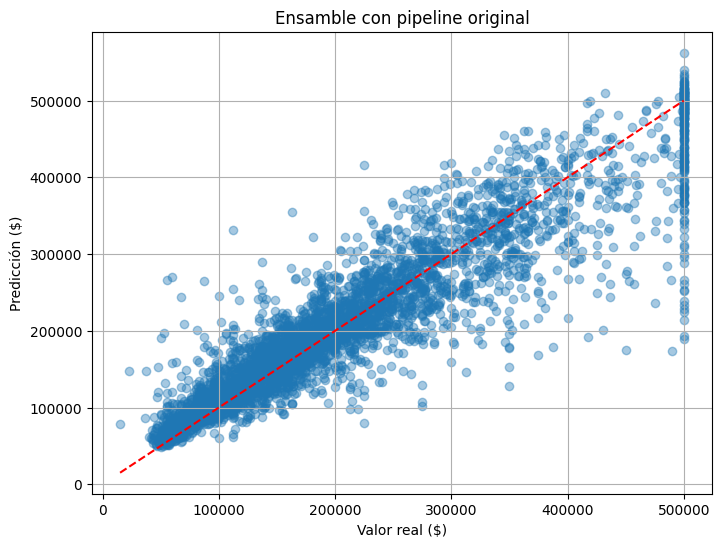

In [18]:

model.eval()
with torch.no_grad():
    nn_pred_scaled = model(X_test_tensor).cpu().numpy()
    nn_pred = y_scaler.inverse_transform(nn_pred_scaled.reshape(-1, 1)).flatten()

xgb_pred = xgb_model.predict(X_test_prep)
final_pred = 0.5 * nn_pred + 0.5 * xgb_pred
rmse_ensemble = np.sqrt(mean_squared_error(y_test, final_pred))
print("✅ RMSE test (ensamble con preprocessing.py):", rmse_ensemble)

plt.figure(figsize=(8,6))
plt.scatter(y_test, final_pred, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Valor real ($)")
plt.ylabel("Predicción ($)")
plt.title("Ensamble con pipeline original")
plt.grid(True)
plt.show()
